In [1]:
import glob
import numpy as np

train_path = "./db_dep/train/"
train_files = glob.glob(train_path + "person-*/*.png")

In [319]:
class Merger:
	def __init__(self, shape, batch):
		self.img_idx = 0
		self.average_image = None
		self.batch_size = batch
		self.sum_image = np.zeros(shape[::-1], dtype=np.uint)

	def find_intersection_by_ids(self, xy1: tuple):
		"""
		Find intersection between given array with x and y coordinates and
		coordinates of average image which are not equal 255
		:param xy1: x and y indices
		:return: intersection mask
		"""
		xy2 = np.where(self.average_image < 255)

		x_mask = np.zeros_like(xy1[0], dtype=bool)
		y_mask = np.zeros_like(x_mask)
		i = 0
		for x1, x2 in zip(xy1[0], xy2[0]):
			x_mask[i] = (x1 == x2)
			i += 1
		i = 0
		for y1, y2 in zip(xy1[1], xy2[1]):
			y_mask[i] = (y1 == y2)
			i += 1
		mask = (x_mask & y_mask)
		return mask

	def apply_average(self):
		"""
		Average pixels on intersection of current batch and average image.
		Only non-white pixels are averaged
		"""
		if self.average_image is None:
			self.average_image = self.sum_image

		nonzero_values_ids = np.where(self.sum_image < 255)

		# apply mask
		intersection_mask = self.find_intersection_by_ids(nonzero_values_ids)
		nonzero_values_ids_x, nonzero_values_ids_y = nonzero_values_ids
		nonzero_values_ids_x = nonzero_values_ids_x[intersection_mask]
		nonzero_values_ids_y = nonzero_values_ids_y[intersection_mask]
		nonzero_values_ids = (nonzero_values_ids_x, nonzero_values_ids_y)

		# take chosen values of current image
		cur_nonzero = self.sum_image[nonzero_values_ids]
		# and values with corresponding indices on average image
		av_nonzero = self.average_image[nonzero_values_ids]
		averaged_pixels = 0.5 * (av_nonzero + cur_nonzero / self.batch_size)

		# save average image in memory for next call
		self.average_image[nonzero_values_ids] = averaged_pixels
		self.average_image = self.average_image.astype(np.uint8)

	def merge_to_one(self, image):
		"""
		Merge current image to previous in batch.
		:param image: current input image
		:return: numpy array of the same size with averaged pixels
		"""
		self.sum_image += np.asarray(image)
		if self.img_idx % self.batch_size == 0:
			self.apply_average()
			self.sum_image.fill(0)
		self.img_idx += 1
		return self.average_image
    

./db_dep/train/person-4/frame11_dep.png PNG (116, 120)xL


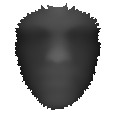

./db_dep/train/person-7/frame11_dep.png PNG (116, 120)xL


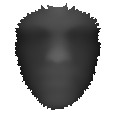

./db_dep/train/person-3/frame11_dep.png PNG (116, 120)xL


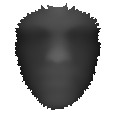

./db_dep/train/person-26/frame11_dep.png PNG (116, 120)xL


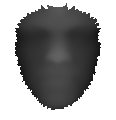

./db_dep/train/person-8/frame11_dep.png PNG (116, 120)xL


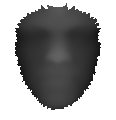

./db_dep/train/person-23/frame11_dep.png PNG (116, 120)xL


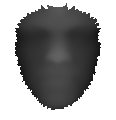

./db_dep/train/person-28/frame11_dep.png PNG (116, 120)xL


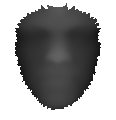

./db_dep/train/person-11/frame11_dep.png PNG (116, 120)xL


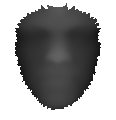

./db_dep/train/person-15/frame11_dep.png PNG (116, 120)xL


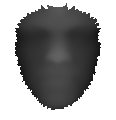

./db_dep/train/person-21/frame11_dep.png PNG (116, 120)xL


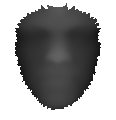

./db_dep/train/person-5/frame11_dep.png PNG (116, 120)xL


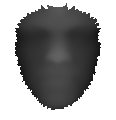

./db_dep/train/person-12/frame11_dep.png PNG (116, 120)xL


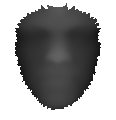

./db_dep/train/person-13/frame11_dep.png PNG (116, 120)xL


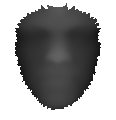

./db_dep/train/person-6/frame11_dep.png PNG (116, 120)xL


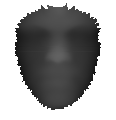

./db_dep/train/person-14/frame11_dep.png PNG (116, 120)xL


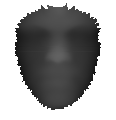

./db_dep/train/person-22/frame11_dep.png PNG (116, 120)xL


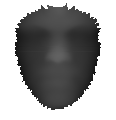

./db_dep/train/person-25/frame11_dep.png PNG (116, 120)xL


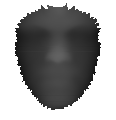

./db_dep/train/person-9/frame11_dep.png PNG (116, 120)xL


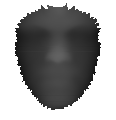

./db_dep/train/person-24/frame11_dep.png PNG (116, 120)xL


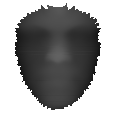

./db_dep/train/person-2/frame11_dep.png PNG (116, 120)xL


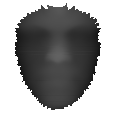

In [320]:
from PIL import Image

img_shape = (116, 120)
batch_size = 1
merger = Merger(img_shape, batch_size)
for infile in train_files:
    try:
        with Image.open(infile) as im:
            if im.mode != "L":
                print("Expected 8-bit pixels, black and white image. Exiting...")
                exit(1)
            print(infile, im.format, f"{im.size}x{im.mode}")
            av_img = merger.merge_to_one(im)
            pil_img = Image.fromarray(av_img, mode="L")
            display(pil_img)
    except OSError:
        pass
pil_img.save("average_image.png")

In [285]:
def test_merging():
    """
    Merge black and then white image with one changed pixel into
    white image with the same changed pixel
    """
    img_shape = (116, 120) # cols, rows
    batch_size = 1
    merger = Merger(img_shape, batch_size)
    pixel_value = 150

    img1 = Image.new("L", img_shape, "white")
    print(img1.size)
    img1.putpixel((0, 0), pixel_value)
    print(np.asarray(img1))
    img2 = Image.new("L", img_shape, "black")
    av_img = merger.merge_to_one(img1)
    print(av_img)
    assert av_img[0, 0] == pixel_value
    assert av_img.shape == img_shape[::-1]
    print(av_img)
    av_img = merger.merge_to_one(img2)
    print(av_img)
    assert av_img[0, 0] == pixel_value / 2
    av_img = merger.merge_to_one(img1)
    print(av_img)
    assert av_img[0, 0] == int((pixel_value / 2 + pixel_value) / 2)

test_merging()

(116, 120)
[[150 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[150 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[150 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[ 75 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]
 ...
 [127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]]
[[112 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]
 ...
 [127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]]


In [307]:
def test_intersection():
    """
    Only matching pixels should be averaged. In this case after merging black image into
    white one only pixel at coordinate (0, 0) is changed
    """
    img_shape = (116, 120) # cols, rows
    batch_size = 1
    merger = Merger(img_shape, batch_size)
    pixel_value = 150

    img1 = Image.new("L", img_shape, "white")
    img1.putpixel((0, 0), pixel_value)
    img2 = Image.new("L", img_shape, "black")
    av_img = merger.merge_to_one(img1)
    av_img = merger.merge_to_one(img2)
    assert av_img[0, 0] == 75
    assert np.all(av_img[0:, 1:] == 255)

test_intersection()

In [318]:
def test_find_intersection_by_ids():
	"""
	Check output intersection mask is correct
	"""
	img_shape = (3, 1) # cols, rows
	batch_size = 1
	merger = Merger(img_shape, batch_size)
	pixel_value = 0

	img1 = Image.new("L", img_shape, "white")
	img1.putpixel((0, 0), pixel_value)
	img1.putpixel((2, 0), pixel_value)
	arr2 = (np.array([0, 0]), np.array([0, 2]))
	av_img = merger.merge_to_one(img1)

	mask = merger.find_intersection_by_ids(arr2)
	assert np.all(mask == [True, True])

test_find_intersection_by_ids()

In [ ]:
img3 = Image.new("RGB", (116, 120), "black")
display(img3)